In [1]:
%matplotlib inline


Filtering and resampling data
=============================




Some artifacts are restricted to certain frequencies and can therefore
be fixed by filtering. An artifact that typically affects only some
frequencies is due to the power line.

Power-line noise is a noise created by the electrical network.
It is composed of sharp peaks at 50Hz (or 60Hz depending on your
geographical location). Some peaks may also be present at the harmonic
frequencies, i.e. the integer multiples of
the power-line frequency, e.g. 100Hz, 150Hz, ... (or 120Hz, 180Hz, ...).

This tutorial covers some basics of how to filter data in MNE-Python.
For more in-depth information about filter design in general and in
MNE-Python in particular, check out [this link](https://martinos.org/mne/stable/auto_tutorials/plot_background_filtering.html)

In [2]:
import mne
from mne.datasets import sample

data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'

Setup for reading the raw data (save memory by cropping the raw data
before loading it)

In [3]:
tmin, tmax = 0, 20  # use the first 20s of data

raw = mne.io.read_raw_fif(raw_fname)
raw.crop(tmin, tmax).load_data()
raw.info['bads'] = ['MEG 2443', 'EEG 053']  # bads + 2 more

Opening raw data file /home/mainak/Desktop/projects/github_repos/mne-python/examples/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0
Reading 0 ... 12012  =      0.000 ...    20.000 secs...


Pick a subset of channels (here for speed reason)

In [4]:
selection = mne.read_selection('Left-temporal')
picks = mne.pick_types(raw.info, meg='mag', eeg=False, eog=False,
                       stim=False, exclude='bads', selection=selection)

Let's first check out all channel types

Effective window size : 3.410 (s)


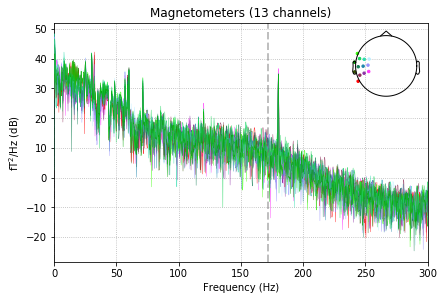

In [5]:
raw.plot_psd(area_mode='range', tmax=10.0, picks=picks, average=False);

Removing power-line noise with notch filtering
----------------------------------------------

Removing power-line noise can be done with a Notch filter, directly on the
Raw object, specifying an array of frequency to be cut off:



Setting up band-stop filter
Filter length of 3965 samples (6.602 sec) selected
Effective window size : 3.410 (s)


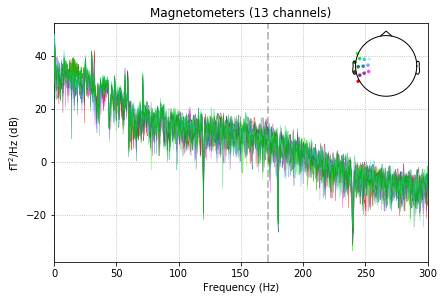

In [6]:
import numpy as np

raw.notch_filter(np.arange(60, 241, 60), picks=picks, filter_length='auto',
                 phase='zero')
raw.plot_psd(area_mode='range', tmax=10.0, picks=picks, average=False);

Removing power-line noise with low-pass filtering
-------------------------------------------------

If you're only interested in low frequencies, below the peaks of power-line
noise you can simply low pass filter the data.



Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 50 Hz
h_trans_bandwidth chosen to be 12.5 Hz
Filter length of 159 samples (0.265 sec) selected
Effective window size : 3.410 (s)


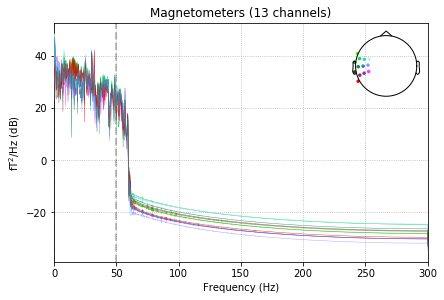

In [7]:
raw.filter(None, 50., fir_design='firwin')
raw.plot_psd(area_mode='range', tmax=10.0, picks=picks, average=False);

High-pass filtering to remove slow drifts
-----------------------------------------

To remove slow drifts, you can high pass.

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz
l_trans_bandwidth chosen to be 1.0 Hz
Filter length of 1983 samples (3.302 sec) selected
Effective window size : 3.410 (s)


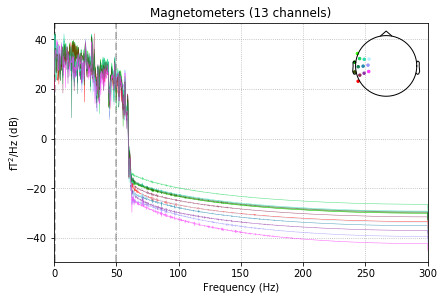

In [8]:
raw.filter(1., None, fir_design='firwin')
raw.plot_psd(area_mode='range', tmax=10.0, picks=picks, average=False);

To do the low-pass and high-pass filtering in one step you can do
a so-called *band-pass* filter by running the following:



In [9]:
raw.filter(1, 50., fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 12.5 Hz
Filter length of 1983 samples (3.302 sec) selected


<Raw  |  sample_audvis_raw.fif, n_channels x n_times : 376 x 12013 (20.0 sec), ~38.1 MB, data loaded>

Downsampling and decimation
--------------------------- 

When performing experiments where timing is critical, a signal with a high
sampling rate is desired.

However, having a signal with a much higher
sampling rate than necessary needlessly consumes memory and slows down
computations operating on the data. To avoid that, you can downsample
your time series.

Data resampling can be done with *resample* methods.

25 events found
Event IDs: [ 1  2  3  4  5 32]
25 events found
Event IDs: [ 1  2  3  4  5 32]
Effective window size : 10.010 (s)


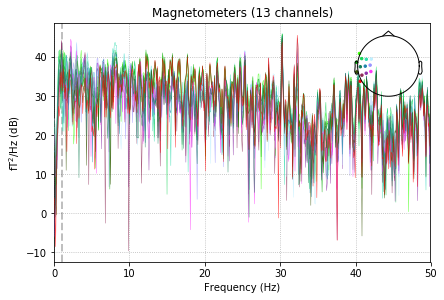

In [10]:
raw.resample(100, npad="auto")  # set sampling frequency to 100Hz
raw.plot_psd(area_mode='range', tmax=10.0, picks=picks);

**Warning**: This will reduce the timing precision of events

To avoid this reduction in precision, the suggested pipeline for
processing final data to be analyzed is:

   1. low-pass the data with `mne.io.Raw.filter`.
   2. Extract epochs with `mne.Epochs`.
   3. Decimate the Epochs object using `mne.Epochs.decimate` or the
      ``decim`` argument to the `mne.Epochs` object.



We also provide the convenience methods `mne.Epochs.resample` and
`mne.Evoked.resample` to downsample or upsample data, but these are
less optimal because they will introduce edge artifacts into every epoch,
whereas filtering the raw data will only introduce edge artifacts only at
the start and end of the recording.

In [1]:
%matplotlib inline

Signal Space Projection (SSP) Math
---------

We can write the measured signal $b \in \mathbb{R}^{C \times T}$ as

$$ b = b_s + b_n$$

where $b_s\in \mathbb{R}^{C \times T}$ is the brain signals and $b_n(t) \in \mathbb{R}^{C \times T}$ is the noise

Noise $b_n$ can be:
* ambient sensor noise
* electrophysiological corruption
 * cardiac
 * ocular

Now, we can apply PCA on $b_n$ and keep only top $M$ components with loadings $ c_n \in \mathbb{R}^M$:
    
$$ b_n = Uc_n + e_n$$

where $U = [b_1, ..., b_M] \in \mathbb{R}^{C \times M}$ are the orthonormal basis.

Now, the SSP operator $P_{\perp} \in \mathbb{R}^{C \times C}$ is given by:

$$ P_{\perp} = I - UU{^\top} $$

so that:

$$b_s \approx P_{\perp}b$$


Artifact Correction with SSP
============================

This tutorial explains how to estimate Signal Subspace Projectors (SSP)
for correction of ECG and EOG artifacts.

In [2]:
import numpy as np

import mne
from mne.datasets import sample
from mne.preprocessing import compute_proj_ecg, compute_proj_eog

# getting some data ready
data_path = sample.data_path()
raw_fname = data_path / 'MEG/sample/sample_audvis_filt-0-40_raw.fif'

raw = mne.io.read_raw_fif(raw_fname, preload=True)

Opening raw data file /Users/mainak/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...


We can see that the raw data has projectors computed but not yet applied.

In [3]:
print(raw.info['projs'])

[<Projection | PCA-v1, active : False, n_channels : 102>, <Projection | PCA-v2, active : False, n_channels : 102>, <Projection | PCA-v3, active : False, n_channels : 102>, <Projection | Average EEG reference, active : False, n_channels : 60>]


Exercise
------------

Where did these projectors come from? What was the noise $b_n$?

To interactively explore the effect of applying proj, use `raw.plot()` and click on the "proj" button

In [4]:
# raw.plot()

Now, we can apply the projectors by doing:

In [5]:
raw.apply_proj()
print(raw.info['projs'])

Created an SSP operator (subspace dimension = 4)
4 projection items activated
SSP projectors applied...
[<Projection | PCA-v1, active : True, n_channels : 102>, <Projection | PCA-v2, active : True, n_channels : 102>, <Projection | PCA-v3, active : True, n_channels : 102>, <Projection | Average EEG reference, active : True, n_channels : 60>]


Compute SSP projections
-----------------------

First let's do ECG.



[<Projection | PCA-v1, active : True, n_channels : 102>, <Projection | PCA-v2, active : True, n_channels : 102>, <Projection | PCA-v3, active : True, n_channels : 102>, <Projection | Average EEG reference, active : True, n_channels : 60>, <Projection | ECG-planar--0.200-0.400-PCA-01, active : False, n_channels : 203, exp. var : 80.13%>, <Projection | ECG-axial--0.200-0.400-PCA-01, active : False, n_channels : 102, exp. var : 95.17%>]


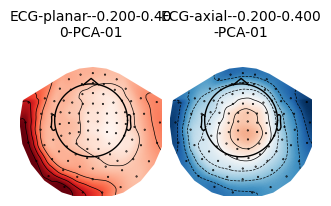

In [6]:
projs, events = compute_proj_ecg(raw, n_grad=1, n_mag=1, n_eeg=0, average=True, verbose=False)
print(projs)

ecg_projs = projs[-2:]
mne.viz.plot_projs_topomap(ecg_projs, info=raw.info);

Now let's do EOG. Here we compute an EEG projector, and need to pass
the measurement info so the topomap coordinates can be created.



[<Projection | PCA-v1, active : True, n_channels : 102>, <Projection | PCA-v2, active : True, n_channels : 102>, <Projection | PCA-v3, active : True, n_channels : 102>, <Projection | Average EEG reference, active : True, n_channels : 60>, <Projection | EOG-planar--0.200-0.200-PCA-01, active : False, n_channels : 203, exp. var : 92.15%>, <Projection | EOG-axial--0.200-0.200-PCA-01, active : False, n_channels : 102, exp. var : 87.40%>, <Projection | EOG-eeg--0.200-0.200-PCA-01, active : False, n_channels : 59, exp. var : 98.50%>]


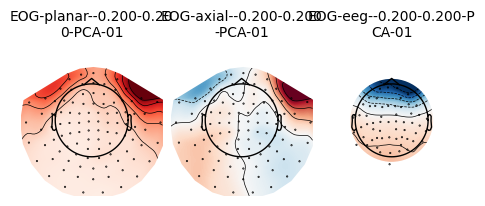

In [7]:
projs, events = compute_proj_eog(raw, n_grad=1, n_mag=1, n_eeg=1, average=True, verbose=False)
print(projs)

eog_projs = projs[-3:]
mne.viz.plot_projs_topomap(eog_projs, info=raw.info);

Exercise
-------------
What are we plotting here? Is it the SSP operator?

Add SSP projections
---------------------

In [8]:
raw = raw.add_proj(eog_projs + ecg_projs)

5 projection items deactivated


Now MNE will apply the projs on demand at any later stage,
so watch out for proj parmeters in functions or to it explicitly
with the ``.apply_proj`` method



Demonstrate SSP cleaning on some evoked data
--------------------------------------------



    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']


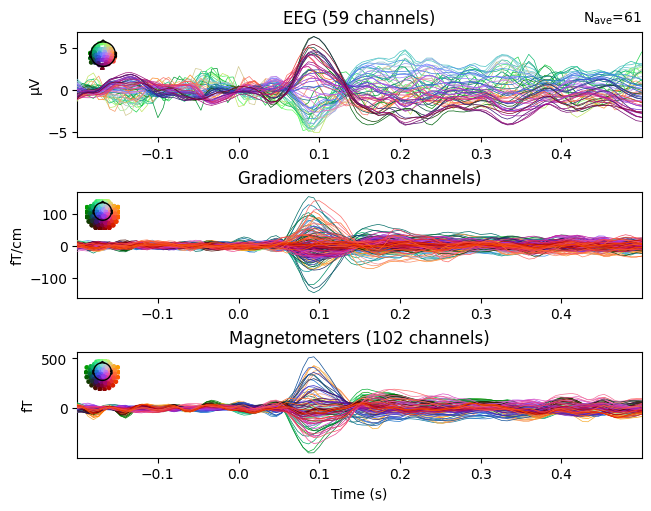

    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']


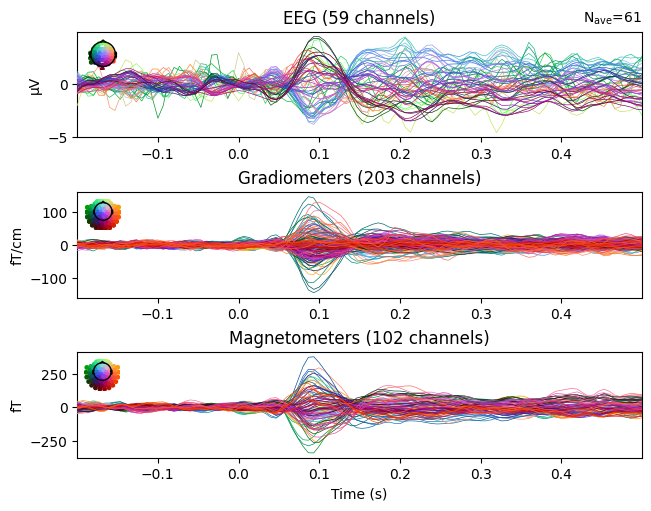

In [9]:
events = mne.find_events(raw, stim_channel='STI 014', verbose=False)
reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)
# this can be highly data dependent
event_id = {'auditory/right': 2}

epochs_no_proj = mne.Epochs(raw, events, event_id, tmin=-0.2, tmax=0.5,
                            proj=False, baseline=(None, 0), reject=reject,
                            verbose=False)
epochs_no_proj.average().plot(spatial_colors=True, time_unit='s');


epochs_proj = mne.Epochs(raw, events, event_id, tmin=-0.2, tmax=0.5, proj=True,
                         baseline=(None, 0), reject=reject, verbose=False)
epochs_proj.average().plot(spatial_colors=True, time_unit='s');

Interactive topomaps with SSP applied

In [10]:
%matplotlib qt

# raw = mne.io.read_raw_fif(raw_fname, preload=True)
evoked = mne.Epochs(raw, events, event_id, tmin=-0.2, tmax=0.5,
                    proj='delayed', baseline=(None, 0),
                    reject=reject, verbose=False).average()

# set time instants in seconds (from 50 to 150ms in a step of 10ms)
times = np.arange(0.05, 0.15, 0.01)

fig = evoked.plot_topomap(times, proj='interactive', time_unit='s');

    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
3 projection items deactivated
Created an SSP operator (subspace dimension = 3)
3 projection items activated
SSP projectors applied...
5 projection items deactivated
Created an SSP operator (subspace dimension = 5)
5 projection items activated
SSP projectors applied...
3 projection items deactivated
Created an SSP operator (subspace dimension = 3)
3 projection items activated
SSP projectors applied...
4 projection items

Now you should see checkboxes. Remove a few SSP and see how the auditory
pattern suddenly drops off



Exercises
---------

1) Can you compute your own proj using empty room data?

In [11]:
erm_fname = data_path / 'sample/MEG/ernoise_raw.fif'
mne.compute_proj_raw?

Signature:
mne.compute_proj_raw(
    raw,
    start=0,
    stop=None,
    duration=1,
    n_grad=2,
    n_mag=2,
    n_eeg=0,
    reject=None,
    flat=None,
    n_jobs=None,
    meg='separate',
    verbose=None,
)
Docstring:
Compute SSP (signal-space projection) vectors on continuous data.

This function aims to find those SSP vectors that
will project out the ``n`` most prominent signals from the data for each
specified sensor type. Consequently, if the provided input data contains high
levels of noise, the produced SSP vectors can then be used to eliminate that
noise from the data.

Parameters
----------
raw : instance of Raw
    A raw object to use the data from.
start : float
    Time (in seconds) to start computing SSP.
stop : float | None
    Time (in seconds) to stop computing SSP. None will go to the end of the file.
duration : float | None
    Duration (in seconds) to chunk data into for SSP
    If duration is ``None``, data will not be chunked.

n_grad : int | float between 

2) How would you compute the SSP from the evoked baseline instead of empty room?

In [12]:
raw = mne.io.read_raw_fif(raw_fname, preload=True, verbose=False)
reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)
evoked = mne.Epochs(raw, events, event_id, tmin=-0.2, tmax=0.5,
                    proj='delayed', baseline=(None, 0),
                    reject=reject, verbose=False).average()

projs = mne.compute_proj_evoked(evoked.copy().crop(tmax=0), n_grad=0, n_mag=2, n_eeg=0)
mne.viz.plot_projs_topomap(projs, info=evoked.info);

    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
Adding projection: axial--0.200-0.000-PCA-01
Adding projection: axial--0.200-0.000-PCA-02


Try making `reject=None`. What happens? Why?

In [1]:
%matplotlib inline

Some ICA math
-------------------

We want to decompose our data $X \in \mathbb{R}^{C \times T}$

$$ X = As $$ 

where $A \in \mathbb{R}^{C \times C}$ is the mixing matrix and $s \in \mathbb{R}^{C \times T}$ are the (independant) latent sources

Each row of $s$ is a statistically independent time series and each column of $A$ is a spatial filter

ICA finds directions in the feature space
corresponding to projections with high non-Gaussianity. We thus obtain
a decomposition into independent components, and the artifact's contribution
is typically localized in only a small number of components.
These components have to be correctly identified and removed.

If EOG or ECG recordings are available, they can be used in ICA to
automatically select the corresponding artifact components from the
decomposition. To do so, you have to first build an `mne.Epochs` object
around blink or heartbeat events.

ICA is implemented in MNE using the `mne.preprocessing.ICA` class,
which we will review here.



First, let us load the data and filter it

In [2]:
import mne
from mne.datasets import sample

# getting some data ready
data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'

raw = mne.io.read_raw_fif(raw_fname, preload=True)

Opening raw data file /local_mount/space/meghnn/1/users/mjas/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Current compensation grade : 0
Reading 0 ... 41699  =      0.000 ...   277.709 secs...


1Hz high pass is often helpful for fitting ICA (already lowpassed @ 40 Hz)

In [3]:
raw.filter(1., None, n_jobs=1, fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz
l_trans_bandwidth chosen to be 1.0 Hz
Filter length of 497 samples (3.310 sec) selected


<Raw  |  sample_audvis_filt-0-40_raw.fif, n_channels x n_times : 376 x 41700 (277.7 sec), ~123.2 MB, data loaded>

The three line summary
----------------------

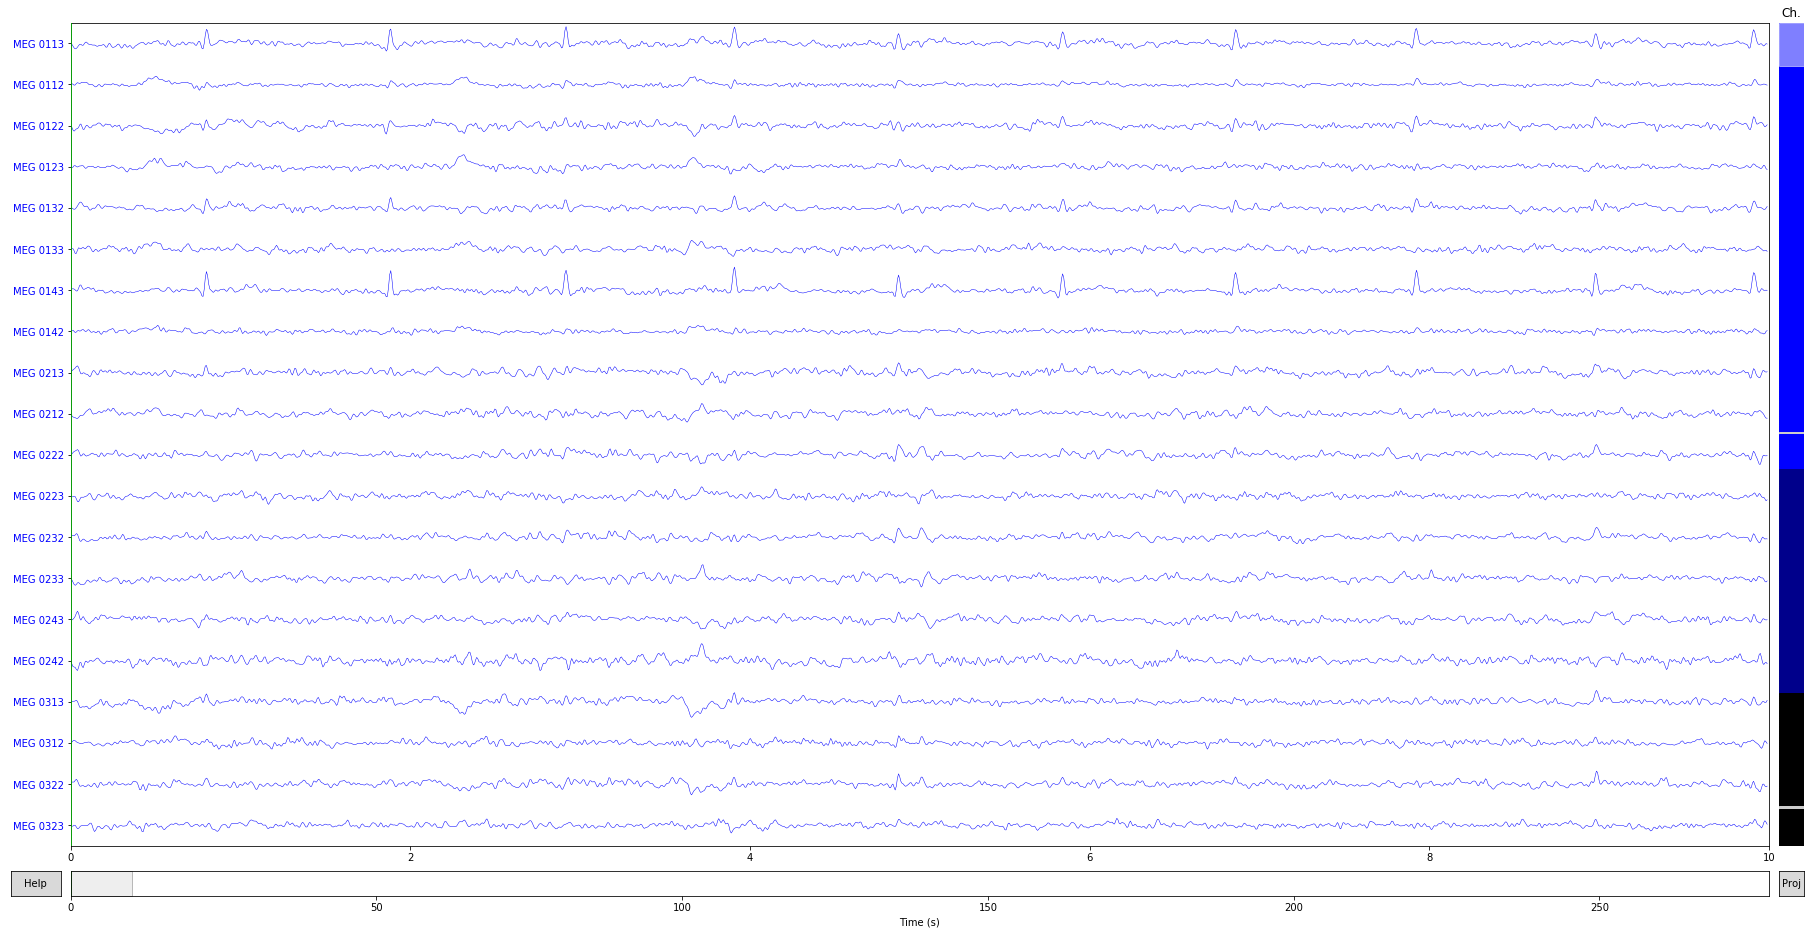

Fitting ICA to data using 364 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 25 components
Fitting ICA took 3.3s.
Transforming to ICA space (25 components)
Zeroing out 1 ICA components


In [4]:
from mne.preprocessing import ICA

raw.plot();
ica = ICA(n_components=25, method='fastica', random_state=23).fit(raw)
ica.exclude = [1]
raw_clean = ica.apply(raw.copy())

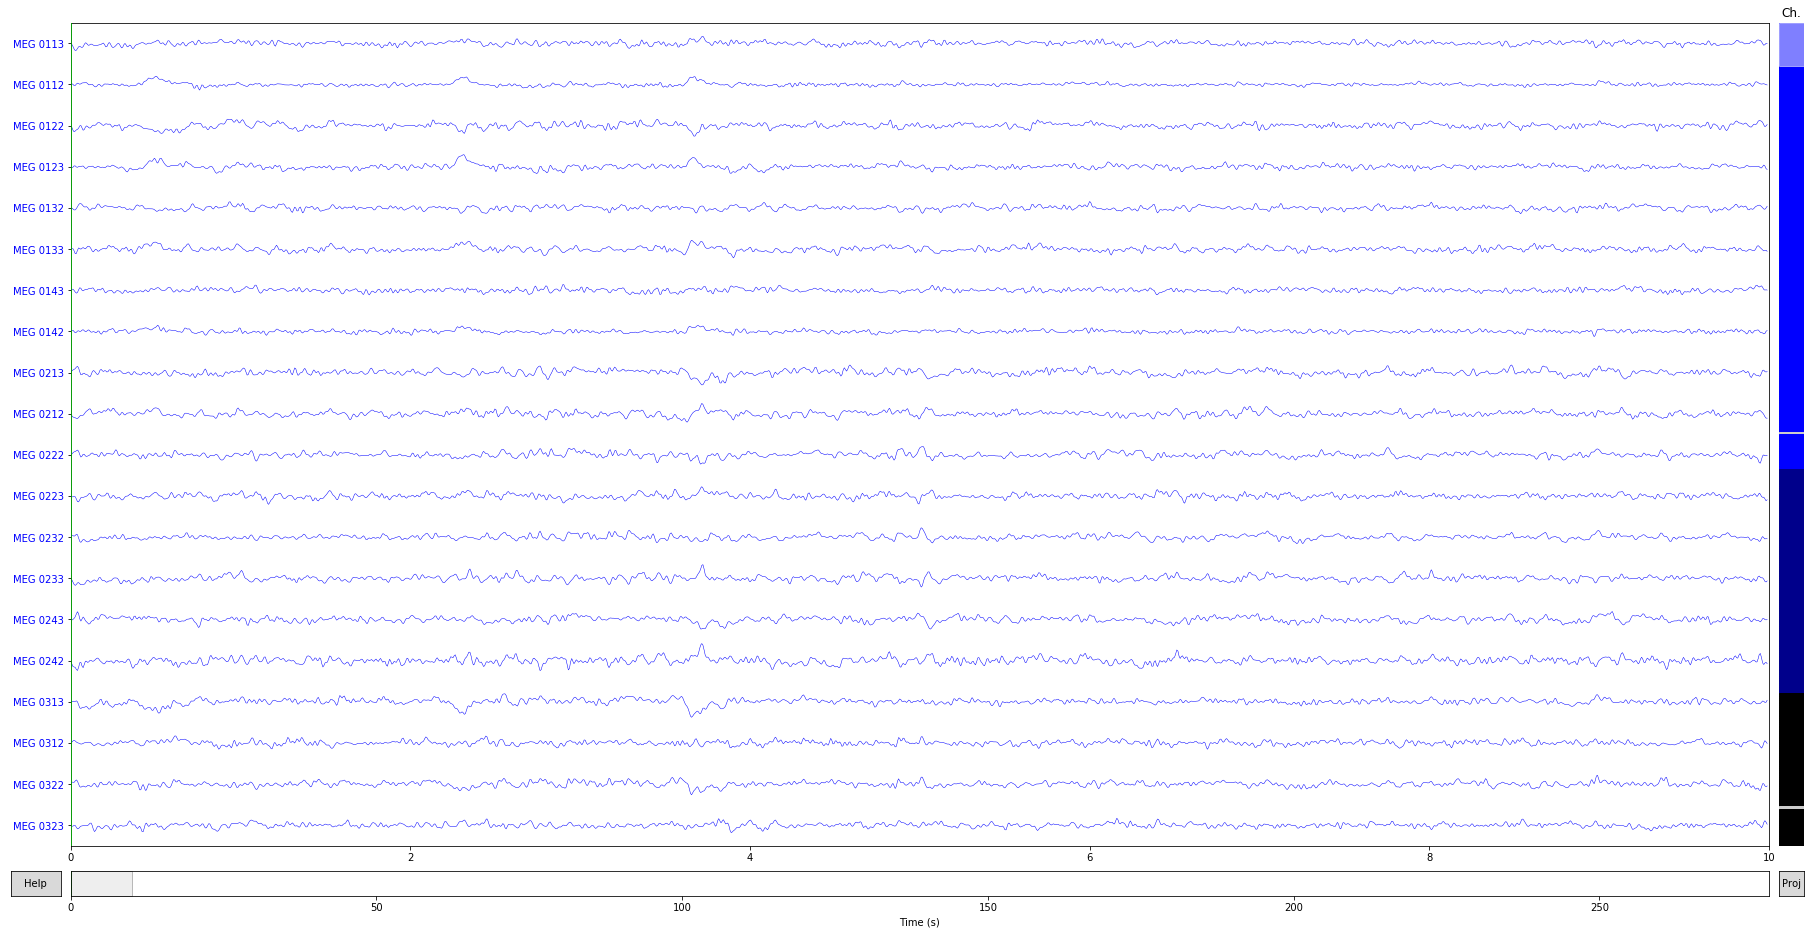

In [5]:
raw_clean.plot();

Fit ICA
-------

First, choose the ICA method. There are currently four possible choices:
`fastica`, `picard`, `infomax` and `extended-infomax`.

In [6]:
method = 'fastica'

# Choose other parameters
n_components = 25  # if float, select n_components by explained variance of PCA
decim = 3  # we need sufficient statistics, not all time points -> saves time

ICA is a non-deterministic algorithm, but we want to have the same decomposition
and the same order of components

In [7]:
random_state = 23

Define the ICA object instance



In [8]:
ica = ICA(n_components=n_components, method=method, random_state=random_state)
print(ica)

<ICA  |  no decomposition, fit (fastica):  samples, no dimension reduction>


We avoid fitting ICA on crazy environmental artifacts that would
dominate the variance and decomposition



In [9]:
reject = dict(mag=5e-12, grad=4000e-13)

picks_meg = mne.pick_types(raw.info, meg=True, eeg=False, eog=False,
                           stim=False, exclude='bads')
ica.fit(raw, picks=picks_meg, decim=decim, reject=reject)
print(ica)

Fitting ICA to data using 305 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
    Rejecting  epoch based on MAG : ['MEG 1711']
Artifact detected in [4242, 4343]
    Rejecting  epoch based on MAG : ['MEG 1711']
Artifact detected in [5858, 5959]
Selection by number: 25 components
Fitting ICA took 1.0s.
<ICA  |  raw data decomposition, fit (fastica): 13635 samples, 25 components, channels used: "mag"; "grad">


Plot ICA components



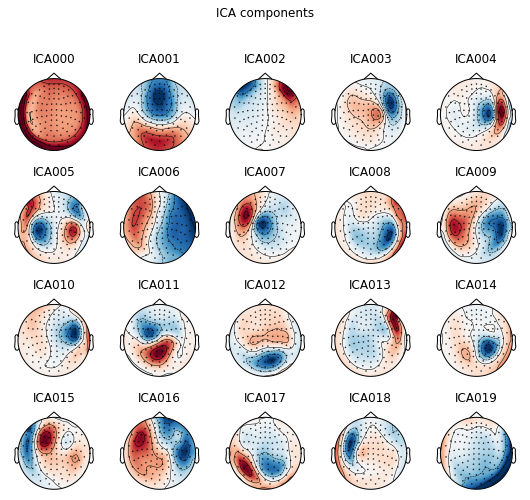

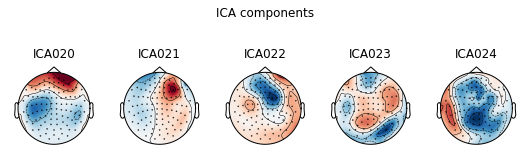

In [10]:
ica.plot_components();  # can you spot some potential bad guys?

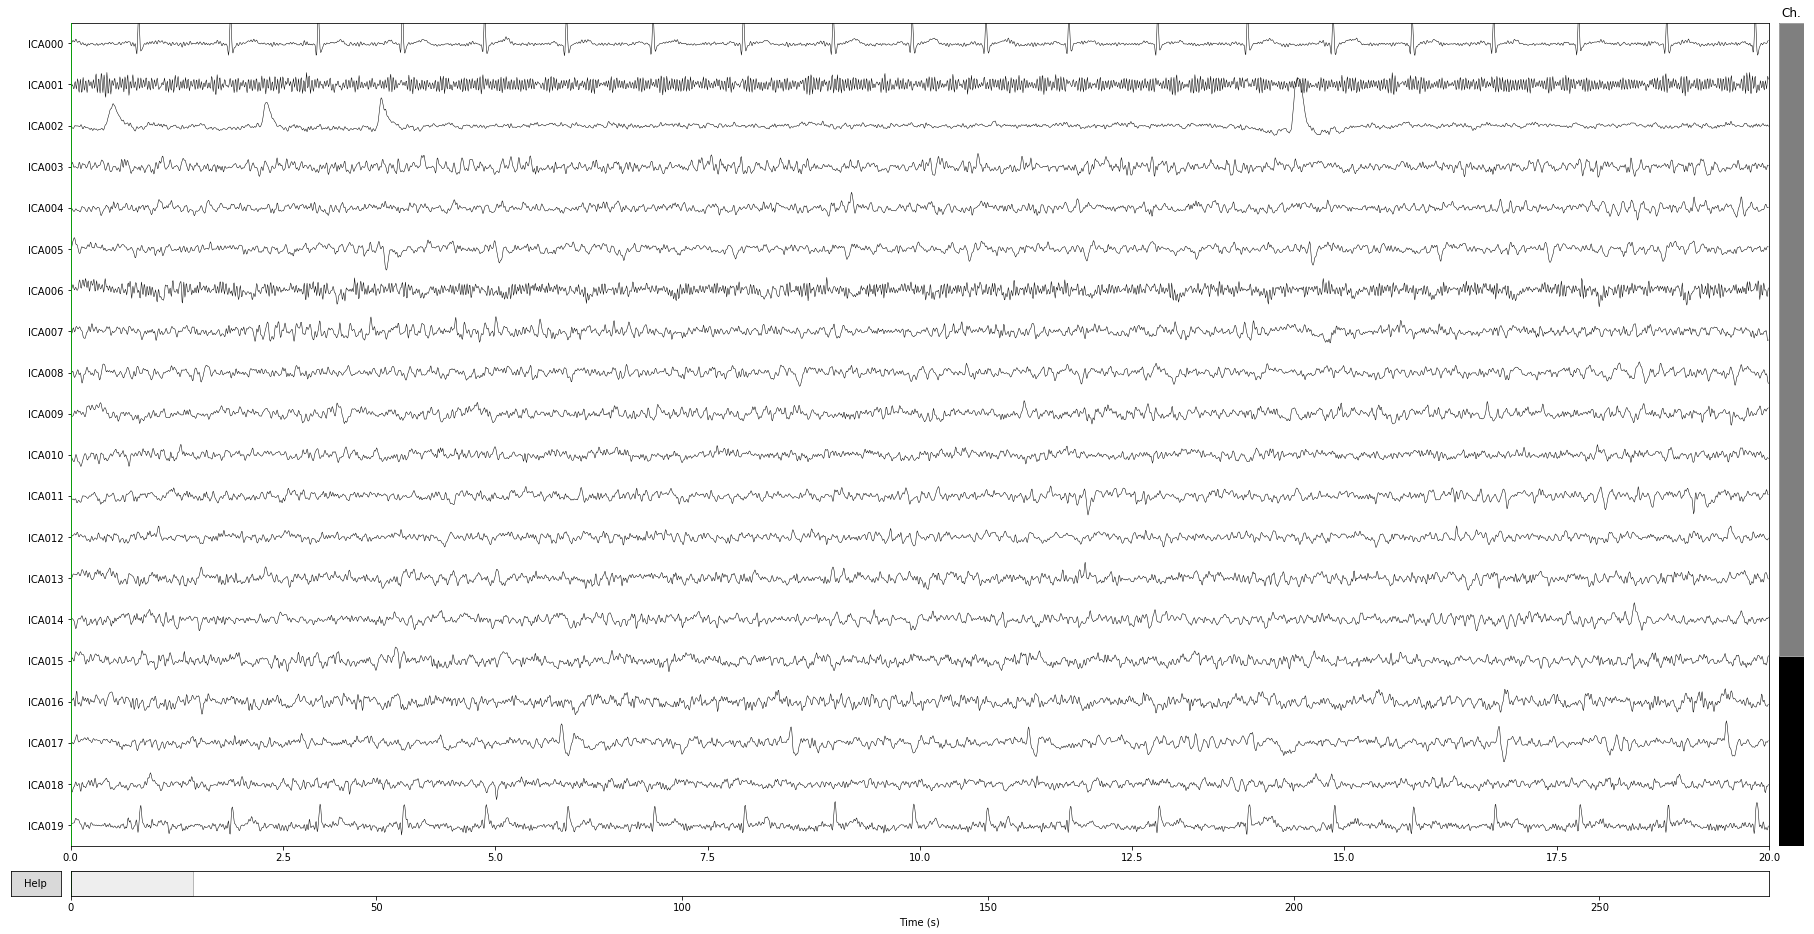

In [11]:
ica.plot_sources(raw);

Component properties
--------------------

Let's take a closer look at properties of first three independent components.



    Rejecting  epoch based on MAG : ['MEG 1711']
Artifact detected in [12642, 12943]
    Rejecting  epoch based on MAG : ['MEG 1711']
Artifact detected in [17458, 17759]
Creating RawArray with float64 data, n_channels=376, n_times=40936
Current compensation grade : 0
    Range : 0 ... 40935 =      0.000 ...   272.621 secs
Ready.
    Using multitaper spectrum estimation with 7 DPSS windows


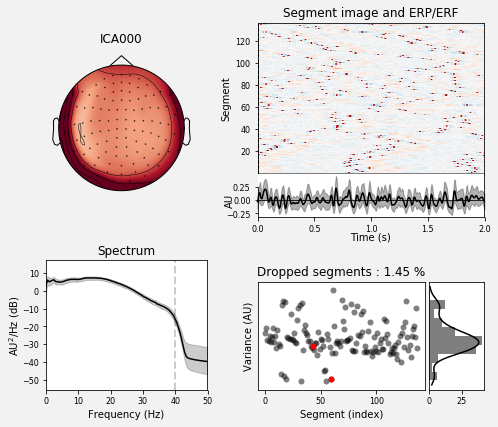

[<Figure size 504x432 with 6 Axes>]

In [12]:
# first, component 0:
ica.plot_properties(raw, picks=0)

Advanced artifact detection
---------------------------

Let's use a more efficient way to find artifacts



In [13]:
from mne.preprocessing import create_eog_epochs

eog_average = create_eog_epochs(raw, reject=dict(mag=5e-12, grad=4000e-13),
                                picks=picks_meg).average()

EOG channel index for this subject is: [375]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 2 - 45 Hz
Filter length of 2048 samples (13.639 sec) selected
Setting up band-pass filter from 1 - 10 Hz
Filter length of 2048 samples (13.639 sec) selected
Now detecting blinks and generating corresponding events
Number of EOG events detected : 46
46 matching events found
No baseline correction applied
Not setting metadata
Created an SSP operator (subspace dimension = 3)
Loading data for 46 events and 151 original time points ...
0 bad epochs dropped


EOG channel index for this subject is: [375]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 2 - 45 Hz
Filter length of 2048 samples (13.639 sec) selected
Setting up band-pass filter from 1 - 10 Hz
Filter length of 2048 samples (13.639 sec) selected
Now detecting blinks and generating corresponding events
Number of EOG events detected : 46
46 matching events found
No baseline correction applied
Not setting metadata
Created an SSP operator (subspace dimension = 4)
Loading data for 46 events and 151 original time points ...
0 bad epochs dropped


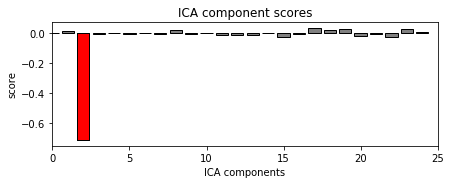

In [14]:
eog_epochs = create_eog_epochs(raw, reject=reject)  # get single EOG trials
eog_inds, scores = ica.find_bads_eog(eog_epochs)  # find via correlation

ica.plot_scores(scores, exclude=eog_inds);  # look at r scores of components

we can see that only one component is highly correlated and that this
component got detected by our correlation analysis (red).

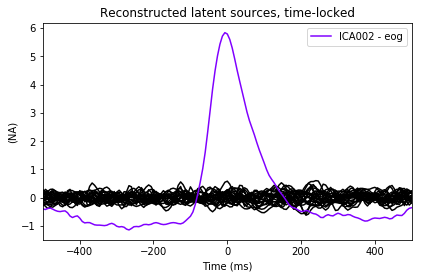

In [15]:
ica.plot_sources(eog_average, exclude=eog_inds);  # look at source time course

We can take a look at the properties of that component, now using the
data epoched with respect to EOG events.
We will also use a little bit of smoothing along the trials axis in the
epochs image:



    Using multitaper spectrum estimation with 7 DPSS windows


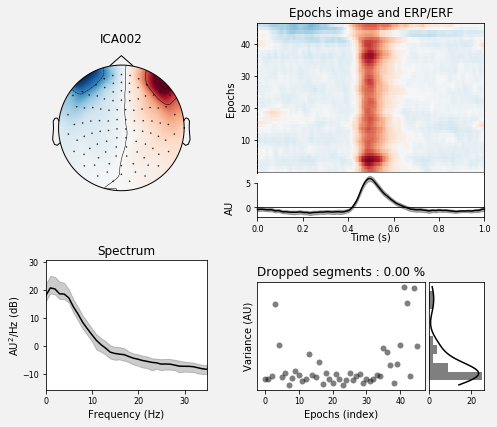

[<Figure size 504x432 with 6 Axes>]

In [16]:
ica.plot_properties(eog_epochs, picks=eog_inds, psd_args={'fmax': 35.},
                    image_args={'sigma': 1.})

Now let's see how we would modify our signals if we removed this component
from the data.


Transforming to ICA space (25 components)
Zeroing out 1 ICA components


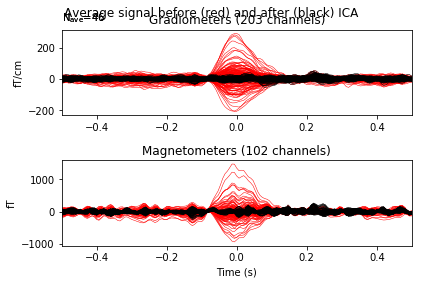

In [17]:
ica.plot_overlay(eog_average, exclude=eog_inds, show=False)
# red -> before, black -> after. Yes! We remove quite a lot!

# to definitely register this component as a bad one to be removed
# there is the ``ica.exclude`` attribute, a simple Python list
ica.exclude.extend(eog_inds)

from now on the ICA will reject this component even if no exclude
parameter is passed, and this information will be stored to disk
on saving

In [18]:
# uncomment this for reading and writing
# ica.save('my-ica.fif')
# ica = read_ica('my-ica.fif')

Note that nothing is yet removed from the raw data. To remove the effects of
the rejected components, `mne.preprocessing.ICA.apply` must be called.
Here we apply it on the copy of the first ten seconds, so that the rest of
this tutorial still works as intended.

Transforming to ICA space (25 components)
Zeroing out 1 ICA components


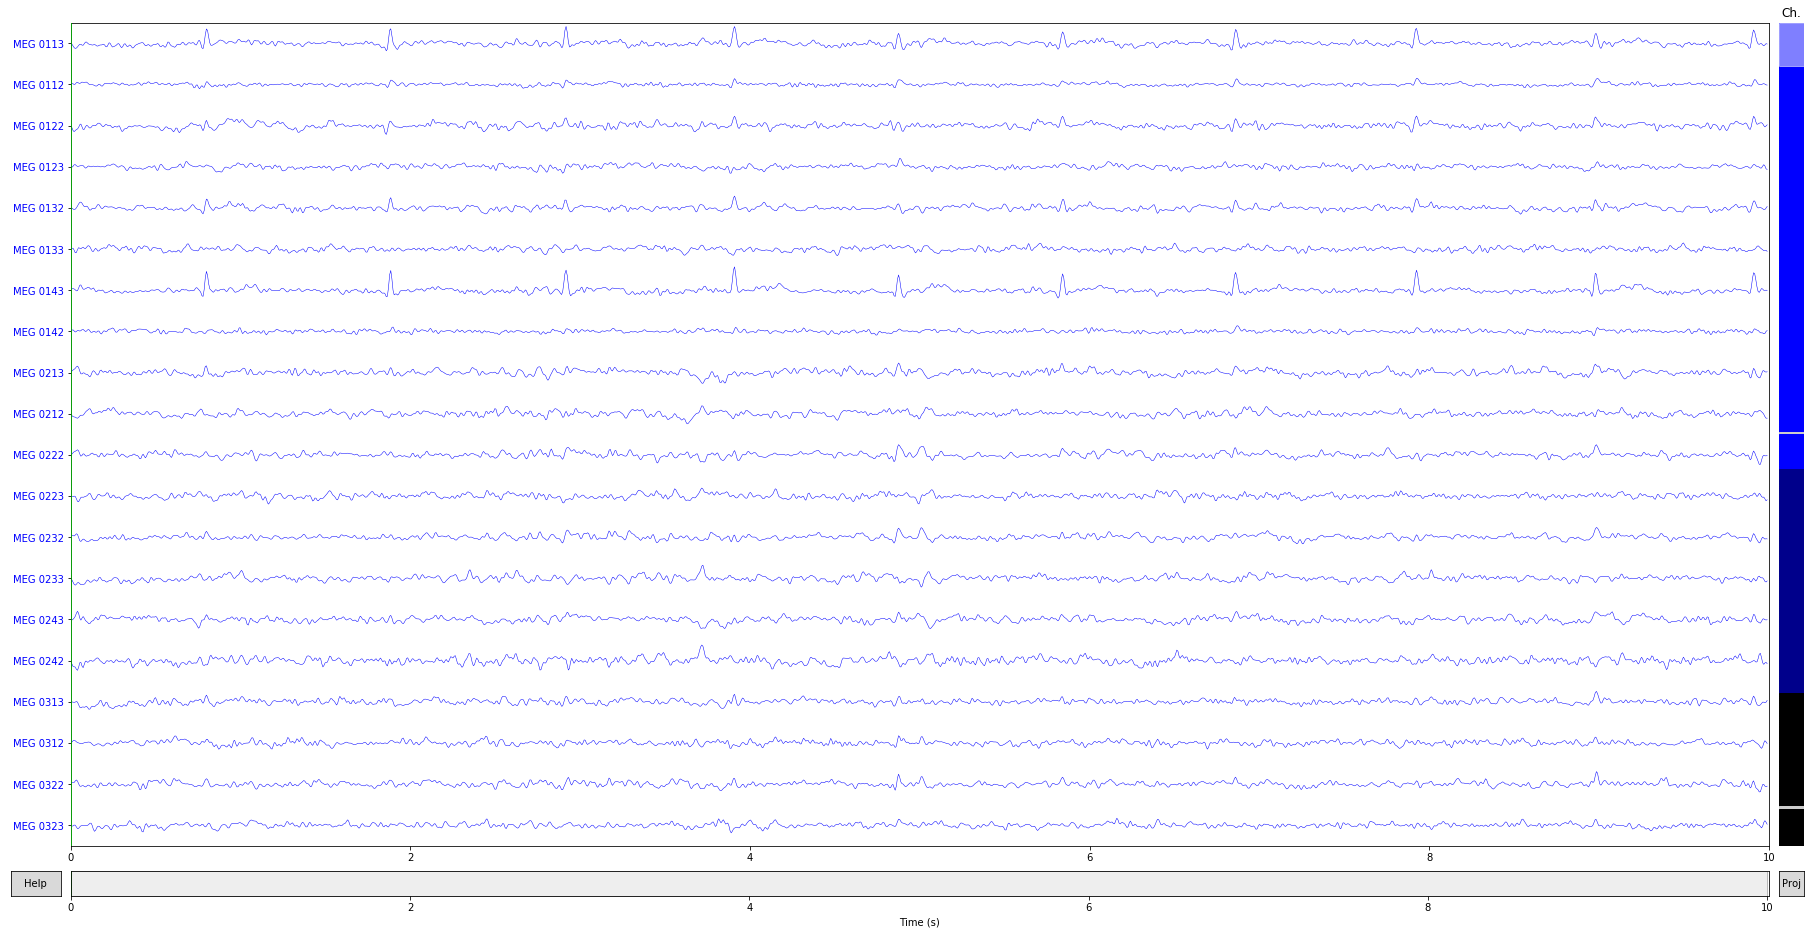

In [19]:
raw_copy = raw.copy().crop(0, 10)
ica.apply(raw_copy)
raw_copy.plot();  # check the result

Exercise
-------------

Find and remove ECG artifacts using ICA!



In [20]:
from mne.preprocessing import create_ecg_epochs